This Jupyter notebook is based on the blog by Dr. Jason Brownlee.

The problem is to predict the number of monthly sales of champagne for the Perrin Freres label (named for a region in France). The dataset provides the number of monthly sales of champagne from January 1964 to September 1972, or just under 10 years of data. The values are a count of millions of sales and there are 105 observations.

https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/

In [1]:
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)

scipy: 0.19.0
numpy: 1.12.1
matplotlib: 2.0.2
pandas: 0.20.1
sklearn: 0.19.0
statsmodels: 0.8.0


We withhold the last one year of data from training. Use the data for validation. 

In [2]:
from pandas import Series


# load the dataset as a Pandas Series
series = Series.from_csv('champagne.csv', header=0)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 93, Validation 12


The saved datasets (dataset.csv and validation.csv) do not have a header line. The validation dataset is about 11% of the original dataset. 

Model evaluation will only be performed on the data in dataset.csv

** prepare data **

In [3]:
series = Series.from_csv('dataset.csv', header=0)

X = series.values
# convert to float32 in case of some data with string or integer data types
X = X.astype('float32')
# split full data set into traing and testing in halves
# The first 50% of the dataset will be used for training
# The remaining 50% of the dataset will be used for testing
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [7]:
train

array([ 2672.,  2755.,  2721.,  2946.,  3036.,  2282.,  2212.,  2922.,
        4301.,  5764.,  7312.,  2541.,  2475.,  3031.,  3266.,  3776.,
        3230.,  3028.,  1759.,  3595.,  4474.,  6838.,  8357.,  3113.,
        3006.,  4047.,  3523.,  3937.,  3986.,  3260.,  1573.,  3528.,
        5211.,  7614.,  9254.,  5375.,  3088.,  3718.,  4514.,  4520.,
        4539.,  3663.,  1643.,  4739.,  5428.,  8314.], dtype=float32)

In [5]:
# walk-forward validation
history = [x for x in train]
predictions = list()

# use the previous number to predict the current
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

>Predicted=8314.000, Expected=10651
>Predicted=10651.000, Expected=3633
>Predicted=3633.000, Expected=4292
>Predicted=4292.000, Expected=4154
>Predicted=4154.000, Expected=4121
>Predicted=4121.000, Expected=4647
>Predicted=4647.000, Expected=4753
>Predicted=4753.000, Expected=3965
>Predicted=3965.000, Expected=1723
>Predicted=1723.000, Expected=5048
>Predicted=5048.000, Expected=6922
>Predicted=6922.000, Expected=9858
>Predicted=9858.000, Expected=11331
>Predicted=11331.000, Expected=4016
>Predicted=4016.000, Expected=3957
>Predicted=3957.000, Expected=4510
>Predicted=4510.000, Expected=4276
>Predicted=4276.000, Expected=4968
>Predicted=4968.000, Expected=4677
>Predicted=4677.000, Expected=3523
>Predicted=3523.000, Expected=1821
>Predicted=1821.000, Expected=5222
>Predicted=5222.000, Expected=6872
>Predicted=6872.000, Expected=10803
>Predicted=10803.000, Expected=13916
>Predicted=13916.000, Expected=2639
>Predicted=2639.000, Expected=2899
>Predicted=2899.000, Expected=3370
>Predicted=3

In [6]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print 'RMSE: %.3f' % rmse

RMSE: 3192.720


Using the most naiive method for prediction (make prediction for current data point using previous data value), we establish a baseline prediction method and preformance. 

This simple method is called **"walk-forward validation"**.

** Summary statistics **

In [10]:
series = Series.from_csv('dataset.csv')
print series.describe()

count       93.000000
mean      4641.118280
std       2486.403841
min       1573.000000
25%       3036.000000
50%       4016.000000
75%       5048.000000
max      13916.000000
dtype: float64


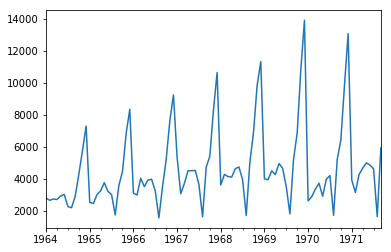

In [11]:
from matplotlib import pyplot

series.plot()
pyplot.show()

** ARIMA Models **

An ARIMA (**Autoregressive Integrated Moving Average**) model is **a class of statistical model** for **analyzing** and **forecasting time series** data.

Autoregression: uses observations from previous time steps as input to a regression equation to predict the value at the next time step.

Integrated: uses differencing of raw observations in order to make the time series stationary.

Moving average: uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

The ARIMA(p, d, q) model requires three parameters and is traditionally configured manually. 

The seasonality in the series is seemingly year-to-year. Seasonal data can be differenced by subtracting the observation from the same time in the previous cycle, in this case the same month in the previous year. This does mean that we will lose the first year of observations as there is no prior year to difference with.

By doing this, we can confirm the resulting dataset is stationary using a statistical test.

In [12]:
from statsmodels.tsa.stattools import adfuller

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

series = Series.from_csv('dataset.csv')
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]

/home/tqi/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [13]:
stationary

1965-01-01    -274.0
1965-02-01    -197.0
1965-03-01     276.0
1965-04-01     545.0
1965-05-01     830.0
1965-06-01     194.0
1965-07-01     746.0
1965-08-01    -453.0
1965-09-01     673.0
1965-10-01     173.0
1965-11-01    1074.0
1965-12-01    1045.0
1966-01-01     572.0
1966-02-01     531.0
1966-03-01    1016.0
1966-04-01     257.0
1966-05-01     161.0
1966-06-01     756.0
1966-07-01     232.0
1966-08-01    -186.0
1966-09-01     -67.0
1966-10-01     737.0
1966-11-01     776.0
1966-12-01     897.0
1967-01-01    2262.0
1967-02-01      82.0
1967-03-01    -329.0
1967-04-01     991.0
1967-05-01     583.0
1967-06-01     553.0
               ...  
1969-04-01     155.0
1969-05-01     321.0
1969-06-01     -76.0
1969-07-01    -442.0
1969-08-01      98.0
1969-09-01     174.0
1969-10-01     -50.0
1969-11-01     945.0
1969-12-01    2585.0
1970-01-01   -1377.0
1970-02-01   -1058.0
1970-03-01   -1140.0
1970-04-01    -536.0
1970-05-01   -2041.0
1970-06-01    -691.0
1970-07-01     694.0
1970-08-01   

ADF Statistic: -7.134898
p-value: 0.000000
Critical Values:
	5%: -2.898
	1%: -3.515
	10%: -2.586


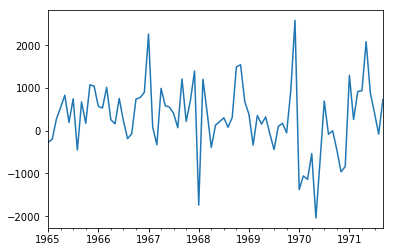

In [14]:
# check if stationary
# adfuller: Augmented Dickey–Fuller test
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv')
# plot
stationary.plot()
pyplot.show()

The results show that the test statistic value -7.134898 is smaller than the critical value at 1% of -3.515. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

**More negative ADF statistic means NO time-dependent structure in the time series.**

**Select the ARIMA model parameters**

The lag values of the Autogression (AR) and Moving Average (MA) parameters, p and p need to be selected. 

We can do this by reviewing Autocorrelation function (ACF) and Partial Autocorrelation Function (PACF) plots. 

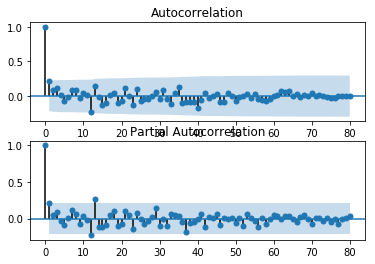

In [15]:
# Create ACF and PACP plots

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
series = Series.from_csv('stationary.csv')
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show()

The ACF shoes a significant lag for 1 month.

The PACF shows a significant lag for 1 month, perhaps some significant lag at 12 and 13 months.

A good starting point for the p and q values is 1.

**Bellow is the script of complete ARIMA analysis, with grid search ARIMA hyperparameters**

In [16]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # difference data
        months_in_year = 12
        diff = difference(history, months_in_year)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, months_in_year)
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:  
            for q in q_values:
                order = (p,d,q) 
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# load dataset
series = Series.from_csv('dataset.csv')
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=939.464
ARIMA(0, 0, 2) RMSE=962.289
ARIMA(0, 0, 3) RMSE=944.237
ARIMA(0, 0, 4) RMSE=958.784
ARIMA(0, 0, 5) RMSE=986.832
ARIMA(0, 0, 6) RMSE=1087.028
ARIMA(0, 1, 1) RMSE=958.300
ARIMA(0, 2, 1) RMSE=1146.987
ARIMA(1, 0, 0) RMSE=944.449
ARIMA(1, 1, 0) RMSE=1070.204
ARIMA(1, 1, 1) RMSE=956.945
ARIMA(1, 2, 0) RMSE=1555.858
ARIMA(2, 0, 0) RMSE=955.134
ARIMA(2, 1, 0) RMSE=1030.467
ARIMA(2, 1, 1) RMSE=980.956
ARIMA(2, 2, 0) RMSE=1346.598
ARIMA(2, 2, 1) RMSE=1039.673
ARIMA(3, 0, 0) RMSE=959.165
ARIMA(3, 1, 0) RMSE=1028.226
ARIMA(3, 1, 1) RMSE=979.938
ARIMA(3, 2, 0) RMSE=1244.846
ARIMA(4, 0, 0) RMSE=968.411
ARIMA(4, 1, 0) RMSE=1046.524
ARIMA(4, 1, 1) RMSE=1006.260
ARIMA(4, 2, 0) RMSE=1227.556
ARIMA(4, 2, 1) RMSE=1055.488
ARIMA(5, 0, 0) RMSE=987.690
ARIMA(5, 1, 0) RMSE=1042.642
ARIMA(5, 1, 1) RMSE=1023.401
ARIMA(5, 1, 2) RMSE=1003.159
ARIMA(5, 2, 1) RMSE=1053.737
ARIMA(6, 0, 0) RMSE=996.466
ARIMA(6, 1, 0) RMSE=1018.211
ARIMA(6, 1, 1) RMSE=1023.761
Best ARIMA(0, 0, 1) RMSE=939.

**Review residual errors**

                 0
count    47.000000
mean    165.904730
std     934.696204
min   -2164.247449
25%    -289.651596
50%     191.759548
75%     732.992187
max    2367.304815


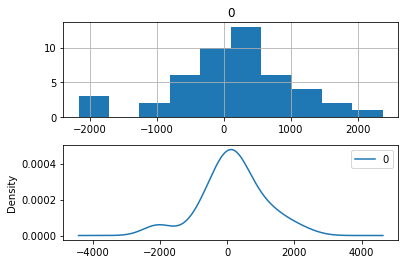

In [17]:
from pandas import Series
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

** Model validation **

In [18]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
import numpy

# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(0,0,1))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual
bias = 165.904728
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

** Make prediction **

>Predicted=6794.773, Expected=6981
>Predicted=10101.763, Expected=9851
>Predicted=13219.067, Expected=12670
>Predicted=3996.535, Expected=4348
>Predicted=3465.934, Expected=3564
>Predicted=4522.683, Expected=4577
>Predicted=4901.336, Expected=4788
>Predicted=5190.094, Expected=4618
>Predicted=4930.190, Expected=5312
>Predicted=4944.785, Expected=4298
>Predicted=1699.409, Expected=1413
>Predicted=6085.324, Expected=5877
RMSE: 361.110


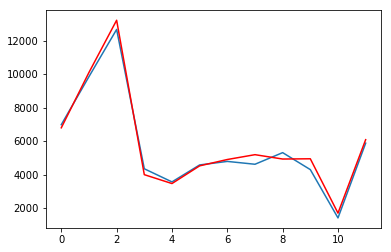

In [20]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load and prepare datasets
dataset = Series.from_csv('dataset.csv')
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = Series.from_csv('validation.csv')
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()